In [17]:
import os
import redshift_connector
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv

In [20]:
load_dotenv(override=True)

True

In [21]:
print("CWD =", os.getcwd())
print("REDSHIFT_HOST repr =", repr(os.getenv("REDSHIFT_HOST")))
print("REDSHIFT_PORT repr =", repr(os.getenv("REDSHIFT_PORT")))
print("REDSHIFT_DB   repr =", repr(os.getenv("REDSHIFT_DB")))
print("REDSHIFT_USER repr =", repr(os.getenv("REDSHIFT_USER")))

CWD = /Users/amaurypaillard/Documents/perso/aws-redshift
REDSHIFT_HOST repr = 'cinestream-redshift-1.crr6vzooh40m.us-east-1.redshift.amazonaws.com'
REDSHIFT_PORT repr = '5439'
REDSHIFT_DB   repr = 'dev'
REDSHIFT_USER repr = 'awsuser'


In [22]:
HOST = os.getenv("REDSHIFT_HOST")
PORT = int(os.getenv("REDSHIFT_PORT", "5439"))
DBNAME = os.getenv("REDSHIFT_DB", "dev")
USER = os.getenv("REDSHIFT_USER")
PASSWORD = os.getenv("REDSHIFT_PASSWORD")
TABLE = os.getenv("REDSHIFT_TABLE", "public.cinestream_fact")

In [23]:
missing = [k for k in ["REDSHIFT_HOST", "REDSHIFT_USER", "REDSHIFT_PASSWORD"] if not os.getenv(k)]
if missing:
    raise ValueError(f"Variables d'env manquantes dans .env: {missing}")

In [24]:
conn = redshift_connector.connect(
    host=HOST,
    port=PORT,
    database=DBNAME,
    user=USER,
    password=PASSWORD,
)

In [31]:
df_tables = pd.read_sql("""
select schemaname, tablename
from pg_table_def
where schemaname not in ('pg_catalog','information_schema')
group by 1,2
order by 1,2;
""", conn)

print(df_tables)

/var/folders/sx/3spdqfdd34jgdzl3whq_df4h0000gn/T/ipykernel_18007/1989279204.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_tables = pd.read_sql("""


Empty DataFrame
Columns: [schemaname, tablename]
Index: []


In [32]:
sql = f"""
SELECT release_year, AVG(rating) AS avg_rating, COUNT(*) AS n
FROM {TABLE}
GROUP BY release_year
ORDER BY release_year;
"""

In [33]:
df = pd.read_sql(sql, conn)
conn.close()

print(df.head(10))

/var/folders/sx/3spdqfdd34jgdzl3whq_df4h0000gn/T/ipykernel_18007/689450572.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, conn)


   release_year  avg_rating   n
0          1902     3.50000   5
1          1903     2.50000   2
2          1908     4.00000   1
3          1915     2.00000   1
4          1916     3.60000   5
5          1917     4.50000   1
6          1919     2.00000   1
7          1920     3.81250   8
8          1921     4.10000   5
9          1922     3.53125  16


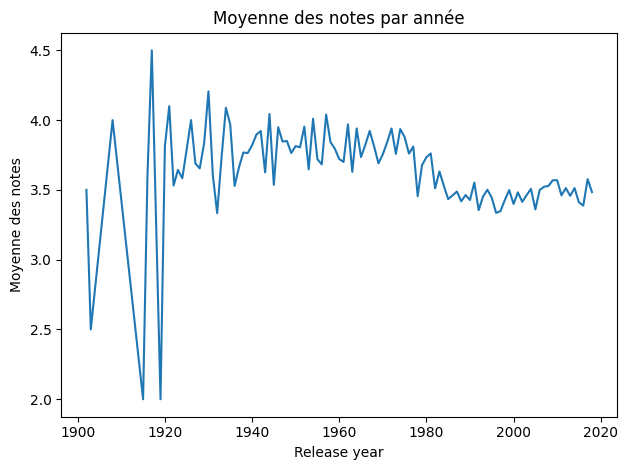

In [35]:
plt.figure()
plt.plot(df["release_year"], df["avg_rating"])
plt.xlabel("Release year")
plt.ylabel("Moyenne des notes")
plt.title("Moyenne des notes par année")
plt.tight_layout()
plt.show()

In [ ]:
# RÉPONSE AUX QUESTIONS

# -- Quelle est la différence fondamentale entre la méthode COPY et la méthode EXTERNAL SCHEMA (Spectrum) ?
# la différence fondamentale entre copy et external schema (spectrum), c’est où les données vivent et comment redshift les lit.

# -- Où résident physiquement les données dans chaque cas ?

# COPY : elles résident physiquement dans redshift
# EXTERNAL SCHEMA : elles restent physiquement dans s3

# -- Quel est l'impact sur le modèle de coût et la performance de lecture ?
# COPY : plus rapide et plus stable en perf, coût: cluster redshift
# EXTERNAL SCHEMA : moins performant que table interne, plus coûteux que COPY à cause de spectrum